In [3]:
import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import time

In [2]:
# sklearnx for speedup
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
from joblib import parallel_backend
import ray
ray.init()
from ray.util.joblib import register_ray
register_ray()

2023-06-06 23:20:40,029	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.multioutput import MultiOutputClassifier

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_curve, roc_auc_score

In [4]:
X_test_raw = pd.read_csv('data/test_set_features.csv')

X_train_raw = pd.read_csv('data/training_set_features.csv')
y_train_raw = pd.read_csv('data/training_set_labels.csv')

In [5]:
X_train_raw.shape

(26707, 36)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_train_raw, y_train_raw, test_size=0.33)

In [ ]:
X_train.head()

In [9]:
y_train

,respondent_id,h1n1_vaccine,seasonal_vaccine
14363,14363,0,1
10162,10162,0,0
21631,21631,1,0
11897,11897,1,1
25599,25599,1,0
...,...,...,...
16233,16233,0,1
4685,4685,0,0
9365,9365,1,1
19569,19569,0,1


In [ ]:
# important columns: h1n1_concern, h1n1_knowledge, 

In [ ]:
# interger encode: education, income_poverity
# one hot encode: age_group, race, sex
                # marital status, rent_or_own, employment_status
                # hhs_geo_region, census_msa, employment_industry,
                # employment_occupation

In [ ]:
# column transformer
    # integer encode ordinal
    # one hot encode nominal
# build pipeline to predict
# try out diff predictors

In [6]:
X_train.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

# EDA

In [55]:
X_train.dtypes

respondent_id                    int64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                      

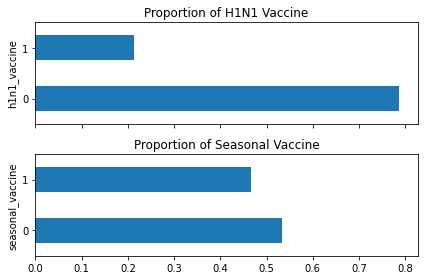

In [60]:
fig, ax = plt.subplots(2, 1, sharex=True)

n_obs = y_train_raw.shape[0]

(y_train_raw['h1n1_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of H1N1 Vaccine", ax=ax[0])
)
ax[0].set_ylabel("h1n1_vaccine")

(y_train_raw['seasonal_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of Seasonal Vaccine", ax=ax[1])
)
ax[1].set_ylabel("seasonal_vaccine")

fig.tight_layout()

In [62]:
# see if variables are independent
pd.crosstab(
    y_train_raw["h1n1_vaccine"], 
    y_train_raw["seasonal_vaccine"], 
    margins=True,
    normalize=True
)

seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.497810,0.289737,0.787546
1,0.036582,0.175871,0.212454
All,0.534392,0.465608,1.000000


In [63]:
# Phi Coefficient is the same as Pearson for two binary variables
(y_train_raw["h1n1_vaccine"]
     .corr(y_train_raw["seasonal_vaccine"], method="pearson")
)

0.37714265306144684

In [64]:
# finding which cols might be correlated with target variable

In [68]:
joined_raw = X_train_raw.merge(y_train_raw, on='respondent_id')

In [78]:
test_counts = joined_raw.groupby(by=['h1n1_concern', 'h1n1_vaccine'])['respondent_id'].count().unstack('h1n1_vaccine')
test_counts

h1n1_vaccine,0,1
h1n1_concern,,
0.0,2849,447
1.0,6756,1397
2.0,8102,2473
3.0,3250,1341


In [83]:
# get normalized counts
full_counts = test_counts.sum(axis=1)
counts_props = test_counts.div(full_counts, axis='index')
counts_props

h1n1_vaccine,0,1
h1n1_concern,,
0.0,0.864381,0.135619
1.0,0.828652,0.171348
2.0,0.766147,0.233853
3.0,0.707907,0.292093


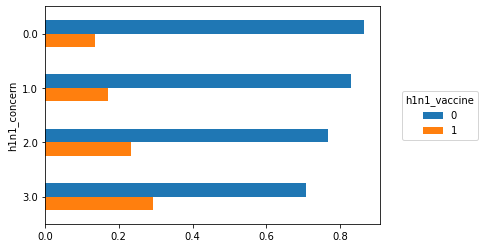

In [84]:
ax = counts_props.plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='h1n1_vaccine'
)

In [89]:
# create function to plot props
def vaccination_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of vaccination rate for `target` against 
    `col`. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = (joined_raw[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

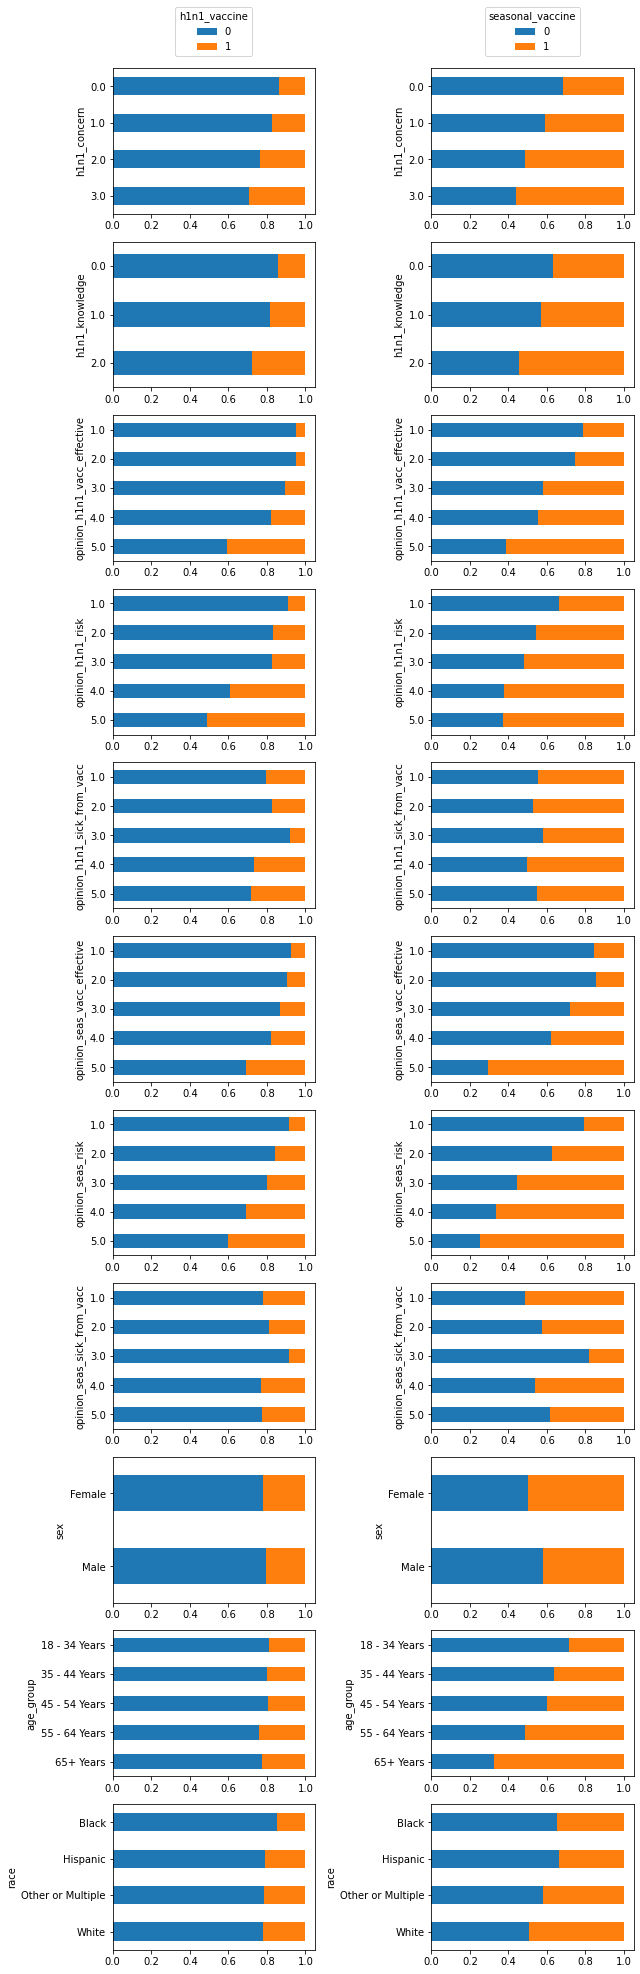

In [90]:
# plot
cols_to_plot = [
    'h1n1_concern',
    'h1n1_knowledge',
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc',
    'sex',
    'age_group',
    'race',
]

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', joined_raw, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', joined_raw, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

# Baseline Model

In [ ]:
# try out simple linear classifier using the cols 
# that are already transformed

# 'h1n1_concern', 'h1n1_knowledge',
# 'behavioral_antiviral_meds', 'behavioral_avoidance',
# 'behavioral_face_mask', 'behavioral_wash_hands',
# 'behavioral_large_gatherings', 'behavioral_outside_home',
# 'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
# 'chronic_med_condition', 'child_under_6_months', 'health_worker',
# 'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
# 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
# 'opinion_seas_risk', 'opinion_seas_sick_from_vacc'


In [ ]:
# drop na, join on id, 

In [20]:
X_base_train_cols = X_train.iloc[:, 0:22]
X_base_train_cols = X_base_train_cols.dropna()
X_base_test_cols = X_test.iloc[:,0:22].dropna()

# merge
full_dropped_train = X_base_train_cols.merge(y_train, how='left', on='respondent_id')
X_base_train = full_dropped_train.iloc[:, 1:-2]
y_base_train = full_dropped_train.iloc[:, -2:]

full_dropped_test = X_base_test_cols.merge(y_test, how='left', on='respondent_id')
X_base_test = full_dropped_test.iloc[:, 1:-2] # get all cols minus respondent_id and target vars
y_base_test = full_dropped_test.iloc[:, -2:] # target vars

In [22]:
clf = MultiOutputClassifier(LogisticRegression()).fit(X_base_train, y_base_train)

In [51]:
base_preds = clf.predict_proba(X_base_test)
base_preds_pd = pd.DataFrame(
    {
        "h1n1_vaccine": base_preds[0][:, 1],
        "seasonal_vaccine": base_preds[1][:, 1],
    }
)

In [52]:
roc_auc_score(y_base_test, base_preds_pd)

0.8556903184753176

# Find most Correlated Columns

In [11]:
# Find features with correlation

In [8]:
# merge y_train_raw and X_train_raw
raw_merged = X_train_raw.merge(y_train_raw, on='respondent_id')

In [ ]:
# use spearman cuz don't know if linear relationship

In [27]:
# get correlations between features and h1n1_vaccine
raw_merged.corr(method='spearman').iloc[:-2,-2].sort_values(ascending=False)

doctor_recc_h1n1               0.393890
opinion_h1n1_risk              0.305840
opinion_h1n1_vacc_effective    0.291602
opinion_seas_risk              0.256199
doctor_recc_seasonal           0.209864
opinion_seas_vacc_effective    0.195961
health_worker                  0.169768
h1n1_concern                   0.122666
health_insurance               0.121170
h1n1_knowledge                 0.120748
chronic_med_condition          0.095207
behavioral_wash_hands          0.074712
behavioral_touch_face          0.071648
behavioral_face_mask           0.070498
child_under_6_months           0.066962
opinion_h1n1_sick_from_vacc    0.059032
behavioral_avoidance           0.047690
behavioral_antiviral_meds      0.040608
behavioral_outside_home        0.021768
behavioral_large_gatherings    0.017822
household_adults               0.013360
household_children            -0.002012
opinion_seas_sick_from_vacc   -0.002808
respondent_id                 -0.003280
Name: h1n1_vaccine, dtype: float64

In [29]:
# get correlations between features and seasonal_vaccine
raw_merged.corr(method='spearman').iloc[:-2,-1].sort_values(ascending=False)

opinion_seas_vacc_effective    0.397874
opinion_seas_risk              0.389286
doctor_recc_seasonal           0.369190
opinion_h1n1_risk              0.219161
opinion_h1n1_vacc_effective    0.201753
health_insurance               0.200858
doctor_recc_h1n1               0.198607
chronic_med_condition          0.170174
h1n1_concern                   0.154467
health_worker                  0.127311
h1n1_knowledge                 0.121633
behavioral_touch_face          0.120228
behavioral_wash_hands          0.112414
behavioral_avoidance           0.076395
behavioral_large_gatherings    0.064025
behavioral_outside_home        0.053509
behavioral_face_mask           0.050083
opinion_h1n1_sick_from_vacc    0.030128
child_under_6_months           0.012097
behavioral_antiviral_meds      0.006277
respondent_id                 -0.004652
household_adults              -0.058912
opinion_seas_sick_from_vacc   -0.075427
household_children            -0.121141
Name: seasonal_vaccine, dtype: float64

In [ ]:
# take the top however many correlated features, test diff combos, and see what produces best results

# 'doctor_recc_h1n1', 'opinion_h1n1_risk', 'opinion_h1n1_vacc_effective', 
# 'opinion_seas_risk', 'doctor_recc_seasonal', 'opinion_seas_vacc_effective', 

In [14]:
X_train_corr_cols = X_train[['respondent_id', 'doctor_recc_h1n1', 'opinion_h1n1_risk', 'opinion_h1n1_vacc_effective', 
                            'opinion_seas_risk', 'doctor_recc_seasonal', 'opinion_seas_vacc_effective']]
X_train_corr_cols = X_train_corr_cols.dropna()
X_test_corr_cols = X_test[['respondent_id', 'doctor_recc_h1n1', 'opinion_h1n1_risk', 'opinion_h1n1_vacc_effective', 
                            'opinion_seas_risk', 'doctor_recc_seasonal', 'opinion_seas_vacc_effective']]\
                            .dropna()

# merge
corr_cols_train = X_train_corr_cols.merge(y_train, how='left', on='respondent_id')
X_corr_train = corr_cols_train.iloc[:, 1:-2]
y_corr_train = corr_cols_train.iloc[:, -2:]

corr_cols_test = X_test_corr_cols.merge(y_test, how='left', on='respondent_id')
X_corr_test = corr_cols_test.iloc[:, 1:-2] # get all cols minus respondent_id and target vars
y_corr_test = corr_cols_test.iloc[:, -2:] # target vars



corr_fit = RidgeClassifierCV().fit(X_corr_train, y_corr_train)

In [15]:
corr_preds = corr_fit.decision_function(X_corr_test)

In [16]:
roc_auc_score(y_corr_test, corr_preds)

0.820134952999298

# Baseline (pipeline)

In [22]:
clf = MultiOutputClassifier(LogisticRegression()).fit(X_base_train, y_base_train)

In [51]:
base_preds = clf.predict_proba(X_base_test)
base_preds_pd = pd.DataFrame(
    {
        "h1n1_vaccine": base_preds[0][:, 1],
        "seasonal_vaccine": base_preds[1][:, 1],
    }
)

In [52]:
roc_auc_score(y_base_test, base_preds_pd)

0.8556903184753176

In [5]:
# get numeric columns
numeric_cols = X_train_raw.columns[X_train_raw.dtypes != "object"].values

In [6]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))
])

# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols)
    ],
    remainder = "drop"
)

In [7]:
# Estimator
estimators = MultiOutputClassifier(
            estimator=LogisticRegression(penalty='l2', C=1)
)

In [8]:
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('estimators', estimators)
])

In [9]:
# training
# 332.3885486125946 w sklearnx
start = time.time()
full_pipeline.fit(X_train, y_train)
end = time.time()
print(end-start)

982.6887810230255


C:\Users\seann\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
base_preds = full_pipeline.predict_proba(X_test)
base_preds

[array([[1.74366310e-05, 4.21734670e-06, 1.40667336e-05, ...,
         2.56444800e-07, 1.23163325e-06, 1.82668359e-07],
        [4.27535860e-06, 2.52131527e-05, 8.52356104e-05, ...,
         3.14294784e-06, 4.76508237e-08, 1.28779855e-06],
        [6.55285386e-05, 1.30060561e-08, 1.77238674e-07, ...,
         2.90482033e-08, 3.21809248e-06, 9.18455873e-07],
        ...,
        [1.10192774e-03, 3.26142746e-05, 8.86892383e-06, ...,
         1.21342328e-06, 6.14954913e-06, 8.52672523e-08],
        [3.12678370e-08, 3.22974047e-06, 6.32781437e-07, ...,
         2.37355987e-06, 3.12380897e-06, 4.29129689e-07],
        [1.15156245e-05, 2.17670396e-05, 1.06801177e-06, ...,
         1.42614348e-05, 8.94816471e-05, 5.31872833e-06]]),
 array([[0.48485845, 0.51514155],
        [0.41727532, 0.58272468],
        [0.98398229, 0.01601771],
        ...,
        [0.68681791, 0.31318209],
        [0.82386492, 0.17613508],
        [0.92861517, 0.07138483]]),
 array([[0.25955378, 0.74044622],
        [0.2

In [ ]:
# try with parallelization
with parallel_backend("ray"):
    start = time.time()
    full_pipeline.fit(X_train, y_train)
    end = time.time()
    print(end-start)

2023-06-06 23:21:35,891	WARNING pool.py:588 -- The 'context' argument is not supported using ray. Please refer to the documentation for how to control ray initialization.


In [13]:
base_preds_pd = pd.DataFrame({
    'h1n1_vaccine': base_preds[1][:,1],
    'seasonal_vaccine': base_preds[2][:,1]
}, index=y_test.index)

roc_auc_score(y_test[['h1n1_vaccine', 'seasonal_vaccine']], base_preds_pd)

0.824557175841147

In [29]:
start = time.time()
# train on full training set
full_pipeline.fit(X_train_raw, y_train_raw)
end = time.time()
print(end - start)

KeyboardInterrupt: 

# Submission

In [ ]:
submission_df.to_csv('my_submission.csv', index=True)

In [7]:
# todo: find best features with correlation,
        # maybe find best for h1n1 and one for flu
        # try multilabel classifier
#      imputation for missing cols?
#      half training dataset for faster training
#      try out different imputers
#      try out correlated columns (see graphs)